In [148]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [149]:
df = pd.read_csv("data.csv", parse_dates=True, index_col="Date")
print(df.head())

            Value
Date             
2023-01-11   10.4
2023-01-12   10.6
2023-01-13   10.8
2023-01-14   11.0
2023-01-15   11.2


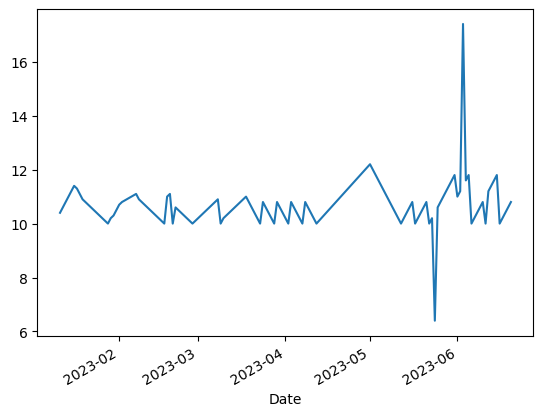

In [150]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

In [151]:
train = df.loc[df.index <= "2023-04-12 00:00:00"]
test = df.loc[df.index > "2023-04-12 00:00:00"]
train.shape, test.shape

((79, 1), (51, 1))

            Value
Date             
2023-01-11   10.4
2023-01-12   10.6
2023-01-13   10.8
2023-01-14   11.0
2023-01-15   11.2


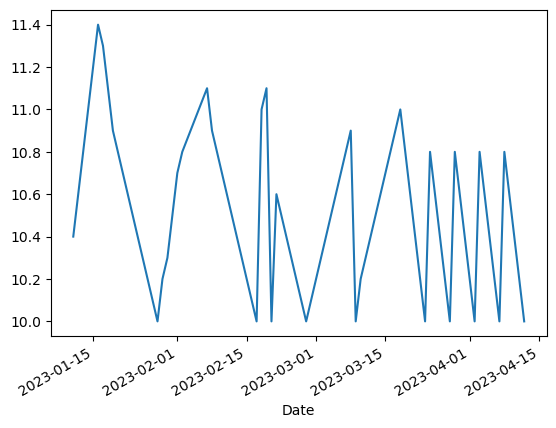

In [152]:
print(train.head())
fig, ax = plt.subplots()
train.plot(legend=False, ax=ax)
plt.show()

            Value
Date             
2023-05-01   12.2
2023-05-02   12.0
2023-05-03   11.8
2023-05-04   11.6
2023-05-05   11.4


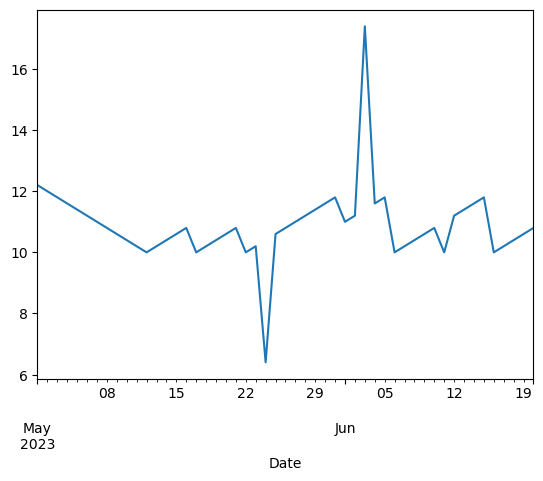

In [153]:
print(test.head())
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

In [154]:
training_mean = train.mean()
training_std = train.std()
df_training_value = (train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 79


In [155]:
TIME_STEPS = 16

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (64, 16, 1)


In [156]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", activation="relu"),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=1, kernel_size=7, padding="same", activation="linear"
        ),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 16, 32)            256       
                                                                 
 dropout_14 (Dropout)        (None, 16, 32)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 16, 16)            3600      
                                                                 
 conv1d_transpose_21 (Conv1D  (None, 16, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 16, 16)            0         
                                                                 
 conv1d_transpose_22 (Conv1D  (None, 16, 32)           3616      
 Transpose)                                           

In [157]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.9182 - val_loss: 0.7696
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 0.8985 - val_loss: 0.7469
Epoch 3/50
1/1 [==============================] - 0s 46ms/step - loss: 0.8762 - val_loss: 0.7238
Epoch 4/50
1/1 [==============================] - 0s 46ms/step - loss: 0.8567 - val_loss: 0.6978
Epoch 5/50
1/1 [==============================] - 0s 43ms/step - loss: 0.8298 - val_loss: 0.6720
Epoch 6/50
1/1 [==============================] - 0s 47ms/step - loss: 0.8062 - val_loss: 0.6465
Epoch 7/50
1/1 [==============================] - 0s 48ms/step - loss: 0.7718 - val_loss: 0.6208
Epoch 8/50
1/1 [==============================] - 0s 43ms/step - loss: 0.7386 - val_loss: 0.5954
Epoch 9/50
1/1 [==============================] - 0s 45ms/step - loss: 0.7081 - val_loss: 0.5708
Epoch 10/50
1/1 [==============================] - 0s 46ms/step - loss: 0.6695 - val_loss: 0.5478
Epoch 11/50
1/1 [==============

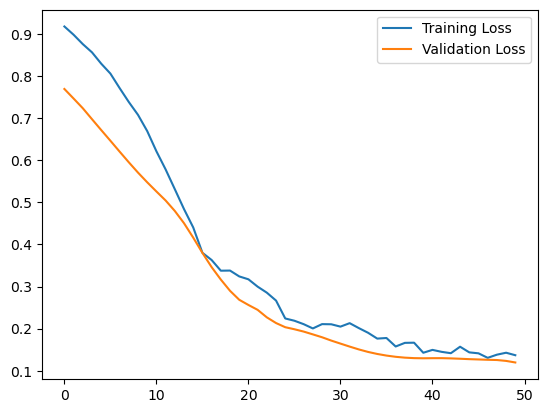

In [158]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


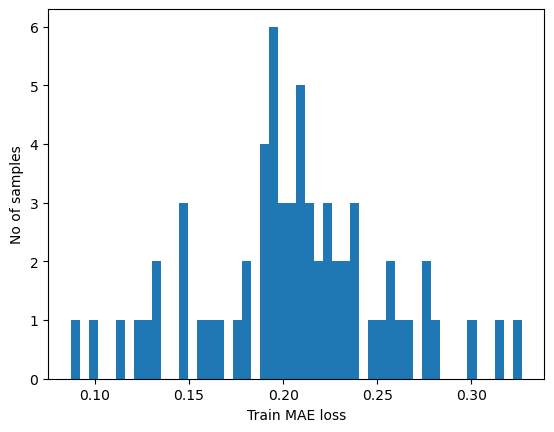

Reconstruction error threshold:  0.32671175643997014


In [159]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

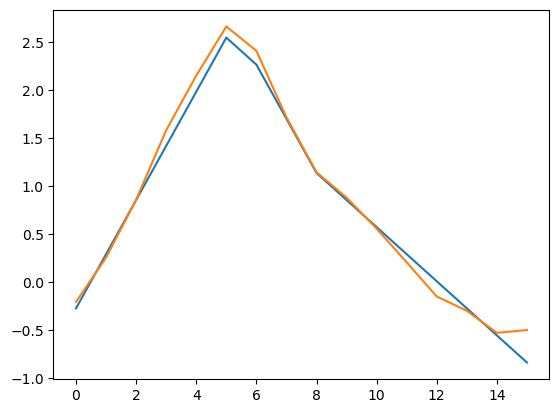

In [160]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

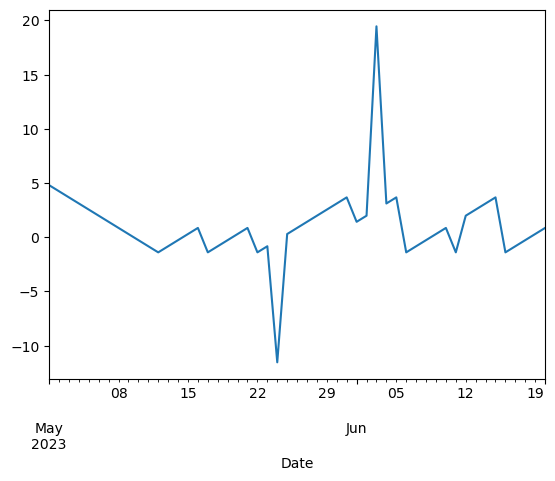

Test input shape:  (36, 16, 1)
2/2 [==============================] - 0s 7ms/step


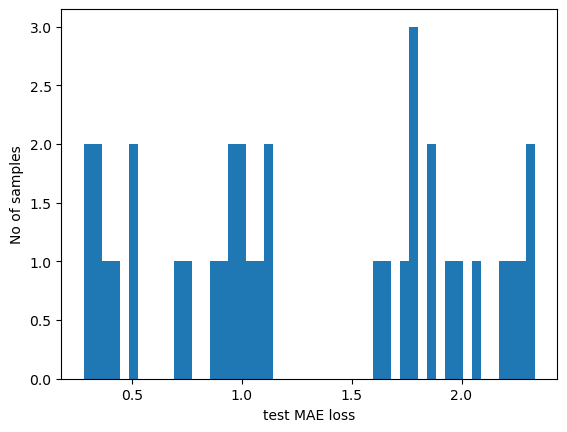

In [161]:
df_test_value = (test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [162]:
anomalies = test_mae_loss > threshold
anomalies_indices = np.where(anomalies)[0]
anomaly_rows = df.iloc[anomalies_indices]

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", anomalies_indices)
print(anomaly_rows)

Number of anomaly samples:  34
Indices of anomaly samples:  [ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35]
            Value
Date             
2023-01-11   10.4
2023-01-12   10.6
2023-01-13   10.8
2023-01-14   11.0
2023-01-15   11.2
2023-01-16   11.4
2023-01-19   10.9
2023-01-20   10.8
2023-01-21   10.7
2023-01-22   10.6
2023-01-23   10.5
2023-01-24   10.4
2023-01-25   10.3
2023-01-26   10.2
2023-01-27   10.1
2023-01-28   10.0
2023-01-29   10.2
2023-01-30   10.3
2023-01-31   10.5
2023-02-01   10.7
2023-02-02   10.8
2023-02-07   11.1
2023-02-08   10.9
2023-02-09   10.8
2023-02-10   10.7
2023-02-11   10.6
2023-02-12   10.5
2023-02-13   10.4
2023-02-14   10.3
2023-02-15   10.2
2023-02-16   10.1
2023-02-17   10.0
2023-02-18   11.0
2023-02-19   11.1


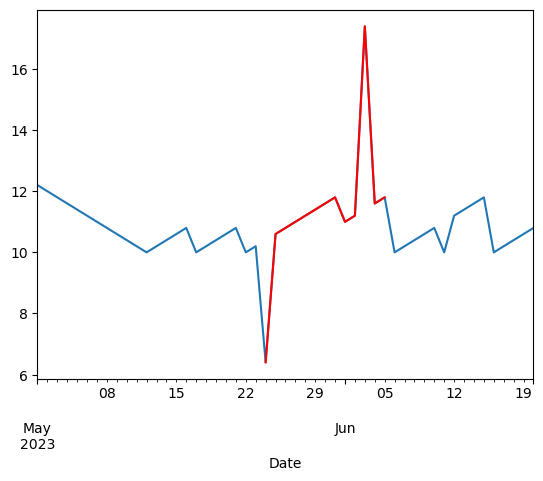

In [163]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()